# Importing the dataset in the Zip Folder

In [1]:
import cv2
import random
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from tensorflow.keras.models import Model
import face_recognition
from skimage import io
from skimage.filters import laplace
from skimage import exposure


In [2]:
# Define the path to the zip file and the extraction path
zip_path = 'nisha.zip'
extraction_path = 'nisha'

In [6]:
# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [3]:

# Listing the contents of the unzipped folder
extracted_files = os.listdir(extraction_path)
print(f"Extracted files and directories: {extracted_files}")

Extracted files and directories: ['Smart attendance dataset']


In [4]:
# Initialize the camera (use 0 for default camera)
cap = cv2.VideoCapture(0)

# Take input of student name and roll number
student_name = input("Enter the student's name: ")
roll_number = input("Enter the student's roll number: ")

# Generate a random number for the student
random_number = random.randint(1000, 9999)

# Define the directory for the train folder
train_dir = os.path.join(extraction_path, 'Smart attendance dataset', 'train')

frame_count = 0

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture frame")
        break

    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Store the key press event in a variable
    key = cv2.waitKey(1) & 0xFF

    # Save the frame when 's' is pressed
    if key == ord('s'):
        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_frame = frame[:, :, ::-1]

        # Find all the faces in the current frame of video
        face_locations = face_recognition.face_locations(rgb_frame)

        # If faces were found, we will mark the image
        for top, right, bottom, left in face_locations:
            # You can access the actual face itself like this:
            face_image = frame[top:bottom, left:right]
            frame_path = os.path.join(train_dir, f'{student_name}.{roll_number}.{random_number}.{frame_count}.jpg')
            cv2.imwrite(frame_path, face_image)
            print(f"Captured frame {frame_count}")
            frame_count += 1

            # Break the loop after capturing 100 frames
            if frame_count >= 100:
                break

    # Break the loop on pressing 'q'
    if key == ord('q'):
        break

# Release the capture and destroy all windows
cap.release()
cv2.destroyAllWindows()

Enter the student's name:  Heroic
Enter the student's roll number:  49


# Getting Information about the Dataset and Exploring the Sample Images

Total images: 1091


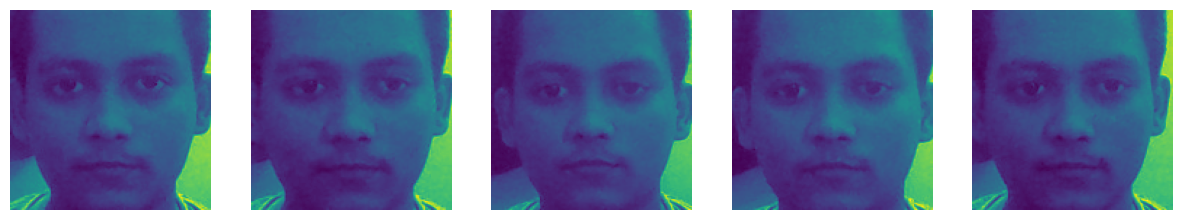

     Dimension  Count
0   (138, 138)     11
1   (134, 134)     11
2   (144, 144)      1
3   (139, 139)      9
4   (136, 136)      8
5   (133, 133)      3
6   (135, 135)     18
7   (140, 140)      5
8   (137, 137)     14
9   (131, 131)      4
10  (130, 130)      3
11  (122, 122)      1
12  (125, 125)      1
13  (132, 132)      1
14  (143, 143)      2
15  (145, 145)      2
16  (151, 151)      3
17  (148, 148)      1
18  (146, 146)      1
19  (142, 142)      1


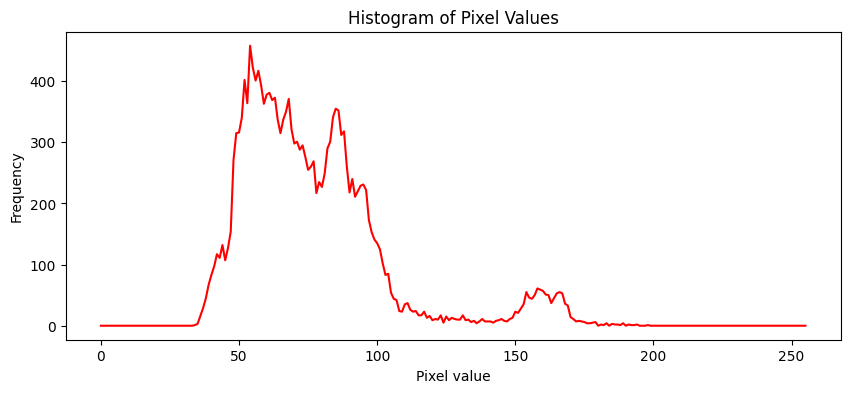

Student ID: Abir, Image Count: 101
Student ID: Fahim, Image Count: 101
Student ID: Gaurav, Image Count: 86
Student ID: Hemel, Image Count: 101
Student ID: Nipa, Image Count: 101
Student ID: Rupak, Image Count: 101
Student ID: Sabiqul, Image Count: 101
Student ID: Shepon, Image Count: 98
Student ID: Tama, Image Count: 100
Student ID: Tamim, Image Count: 100
Student ID: Tarup, Image Count: 101


In [5]:
dataset_path = os.path.join(extraction_path, extracted_files[0])

# Adjust the path to include the 'train' directory
train_path = os.path.join(dataset_path, 'train')

# Exploring the dataset structure
images = os.listdir(train_path)
print(f"Total images: {len(images)}")

# Visualizing a few sample images
sample_images = [os.path.join(train_path, img) for img in images[:5]]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.show()

# Analyzing image dimensions and counting occurrences
dimension_counts = {}
for img_name in images[:100]:  # Analyze a subset of images
    img_path = os.path.join(train_path, img_name)
    with Image.open(img_path) as img:
        dimension = img.size
        if dimension in dimension_counts:
            dimension_counts[dimension] += 1
        else:
            dimension_counts[dimension] = 1

# Create a DataFrame from the dimension counts dictionary
dimensions_df = pd.DataFrame(list(dimension_counts.items()), columns=['Dimension', 'Count'])

# Display the DataFrame as a table
print(dimensions_df)

# Calculate and visualize the histogram of pixel values for the first image
with Image.open(sample_images[0]) as img:
    histogram = img.histogram()
plt.figure(figsize=(10, 4))
plt.plot(histogram[:256], color='r')  # Red channel for RGB image, or grayscale level for L image
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

# Checking the distribution of images per student
student_image_count = {}
for img_name in images:  # Iterate over the list of image filenames
    student_id = img_name.split('.')[0]
    if student_id in student_image_count:
        student_image_count[student_id] += 1
    else:
        student_image_count[student_id] = 1

# Display the distribution of images per student
for student_id, count in sorted(student_image_count.items()):
    print(f"Student ID: {student_id}, Image Count: {count}")

# Pre-Processing of the Dataset

In [6]:
from skimage import io
from skimage.filters import laplace
from skimage import exposure

# Function to assess the blurriness of an image
def calculate_blurriness_score(img_path):
    img = io.imread(img_path, as_gray=True)
    return np.var(laplace(img))

# Calculate the blurriness score for each image
blurriness_scores = [calculate_blurriness_score(os.path.join(train_path, img_name)) for img_name in images[:100]]
print(f"Blurriness score images: {np.sum(blurriness_scores)}")

# Function to assess the contrast of an image
def calculate_contrast_score(img_path):
    img = io.imread(img_path, as_gray=True)
    return exposure.is_low_contrast(img)

# Assess the contrast for each image
contrast_scores = [calculate_contrast_score(os.path.join(train_path, img_name)) for img_name in images[:100]]
print(f"Low contrast images: {np.sum(contrast_scores)}")

# Add the contrast check to the blurriness_scores loop to save computation
for img_name in images[:100]:
    img_path = os.path.join(train_path, img_name)
    blurriness_score = calculate_blurriness_score(img_path)
    is_low_contrast = calculate_contrast_score(img_path)
    print(f"Image: {img_name}, Blurriness: {blurriness_score}, Low Contrast: {is_low_contrast}")

Blurriness score images: 0.11729026806366148
Low contrast images: 0
Image: Abir.6.3051.1.jpg, Blurriness: 0.0017052995547816138, Low Contrast: False
Image: Abir.6.3051.10.jpg, Blurriness: 0.001557203909698011, Low Contrast: False
Image: Abir.6.3051.100.jpg, Blurriness: 0.0014407119056773035, Low Contrast: False
Image: Abir.6.3051.101.jpg, Blurriness: 0.0009223085719620061, Low Contrast: False
Image: Abir.6.3051.11.jpg, Blurriness: 0.0018427664579645437, Low Contrast: False
Image: Abir.6.3051.12.jpg, Blurriness: 0.001699018072639546, Low Contrast: False
Image: Abir.6.3051.13.jpg, Blurriness: 0.0016410909298925484, Low Contrast: False
Image: Abir.6.3051.14.jpg, Blurriness: 0.0015833894960803412, Low Contrast: False
Image: Abir.6.3051.15.jpg, Blurriness: 0.0016237209130569828, Low Contrast: False
Image: Abir.6.3051.16.jpg, Blurriness: 0.001347498192369823, Low Contrast: False
Image: Abir.6.3051.17.jpg, Blurriness: 0.0018423259499878379, Low Contrast: False
Image: Abir.6.3051.18.jpg, Blurr

# Distribution of Images per Student

Statistics of images per student:
count     11.000000
mean      99.181818
std        4.468069
min       86.000000
25%      100.000000
50%      101.000000
75%      101.000000
max      101.000000
dtype: float64


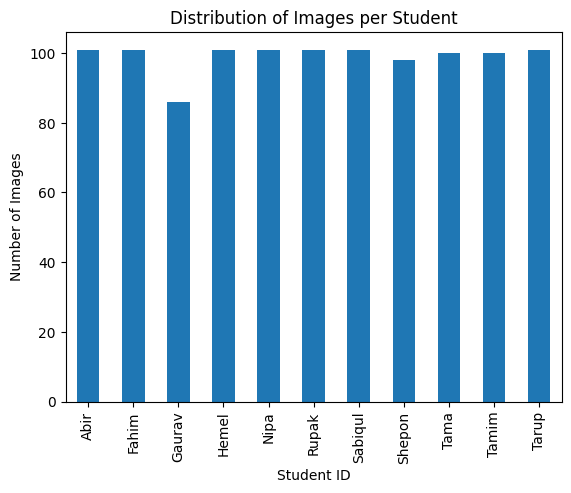

In [7]:
# Analyze the distribution balance
student_counts = pd.Series(student_image_count)
print("Statistics of images per student:")
print(student_counts.describe())

# Visual representation of balance
student_counts.plot(kind='bar')
plt.title('Distribution of Images per Student')
plt.xlabel('Student ID')
plt.ylabel('Number of Images')
plt.show()

# Image Resizing and Processing/Splitting

Train data shape: (872, 128, 128, 1)
Validation data shape: (219, 128, 128, 1)


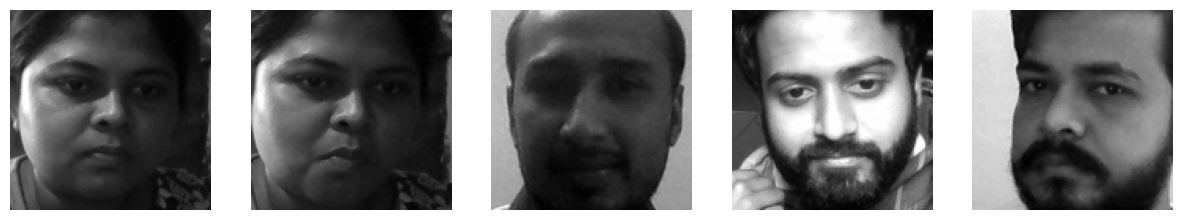

In [8]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Load image
    image = Image.open(image_path)
    # Check if image is not grayscale
    if image.mode != 'L':
        image = image.convert('L')
    # Resize image
    image = image.resize(target_size)
    # Convert image to numpy array and normalize to range [0, 1]
    image_array = np.array(image) / 255.0
    return image_array

# `train_path` is the directory containing the images
train_contents = os.listdir(train_path)

# Initialize lists for storing image data and labels
data = []
labels = []

# Loop over all images and preprocess them
for img_name in train_contents:
    img_path = os.path.join(train_path, img_name)
    img_array = preprocess_image(img_path)
    data.append(img_array)
    # Extracting labels from file names
    labels.append(img_name.split('.')[0])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape data to add channel dimension if model expects
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 1))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotation range in degrees
    width_shift_range=0.1,  # Fraction of total width for horizontal shift
    height_shift_range=0.1,  # Fraction of total height for vertical shift
    shear_range=0.1,  # Shear intensity
    zoom_range=0.1,  # Zoom range
    horizontal_flip=True,  # Enable horizontal flipping of images
    fill_mode='nearest'
)

unique_labels = np.unique(labels)
label_to_int_map = {label: index for index, label in enumerate(unique_labels)}
encoded_labels = np.array([label_to_int_map[label] for label in labels])

# Split the dataset into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, encoded_labels, test_size=0.2, random_state=42
)

# Display the shapes of the training and validation sets
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# visualize some preprocessed images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_array in zip(axes, train_data[:5]):
    ax.imshow(img_array.squeeze(), cmap='gray')  # Use squeeze() to remove single-dimensional entries
    ax.axis('off')
plt.show()


# Generating the Training Data

In [8]:
# Training data generator with augmentation
train_generator = datagen.flow(train_data, train_labels, batch_size=32)

# Validation data generator without augmentation
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(val_data, val_labels, batch_size=32)

# Defining and Loading the CNN Model

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Input(shape=train_data.shape[1:]),  # Use an Input layer as the first layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer with a node for each class
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the CNN model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,612 (12.61 MB)

 Trainable params: 3,305,612 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the CNN Model

In [10]:
# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_data) // 32
val_steps_per_epoch = len(val_data) // 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Rotation range in degrees
    width_shift_range=0.1,  # Fraction of total width for horizontal shift
    height_shift_range=0.1,  # Fraction of total height for vertical shift
    shear_range=0.1,  # Shear intensity
    zoom_range=0.1,  # Zoom range
    horizontal_flip=True,  # Enable horizontal flipping of images
    fill_mode='nearest'
)

# No data augmentation for validation set
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)
validation_generator = val_datagen.flow(val_data, val_labels, batch_size=32)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,  # Number of steps per epoch
    epochs=50,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,  # Number of steps per validation epoch
)

Epoch 1/50


E:\Python3.12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 648ms/step - accuracy: 0.1704 - loss: 2.3583 - val_accuracy: 0.6920 - val_loss: 1.1283
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3438 - loss: 1.9403 - val_accuracy: 0.6667 - val_loss: 1.1839
Epoch 3/50


E:\Python3.12\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5753 - loss: 1.2568 - val_accuracy: 0.9420 - val_loss: 0.3768
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6250 - loss: 1.1713 - val_accuracy: 0.9524 - val_loss: 0.3064
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7277 - loss: 0.7857 - val_accuracy: 0.9554 - val_loss: 0.2015
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.6857 - val_accuracy: 1.0000 - val_loss: 0.0783
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8481 - loss: 0.5423 - val_accuracy: 1.0000 - val_loss: 0.0291
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9688 - loss: 0.2513 - val_accuracy: 1.0000 - val_loss: 0.0334
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8819 - loss: 0.3432 - val_accuracy: 0.9911 - val_loss: 0.0729
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.3303 - val_accuracy: 1.0000 - val_loss: 0.0706
Ep

# Plotting the Training Curves

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, steps=len(val_data) // 32)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Save the Model
model.save('model.h5')


KeyboardInterrupt



<Figure size 1000x500 with 0 Axes>

# Implementing SVM Model

In [12]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load the CNN model
model = load_model('model.h5')

# Create a new model that outputs the activations of the second Dense layer (third from last layer) of the original model
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

# Extract features using the feature extractor
# Replace 'data' with your actual data and 'encoded_labels' with your actual labels
features = feature_extractor.predict(data)

# Split features into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm_classifier.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred)}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step
SVM Accuracy: 1.0


C:\Users\anilw\AppData\Local\Temp\ipykernel_7716\3464705670.py:13: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X_train_pca, y_train.astype(np.integer), clf=svm_classifier_2d, legend=2)
E:\Python3.12\Lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


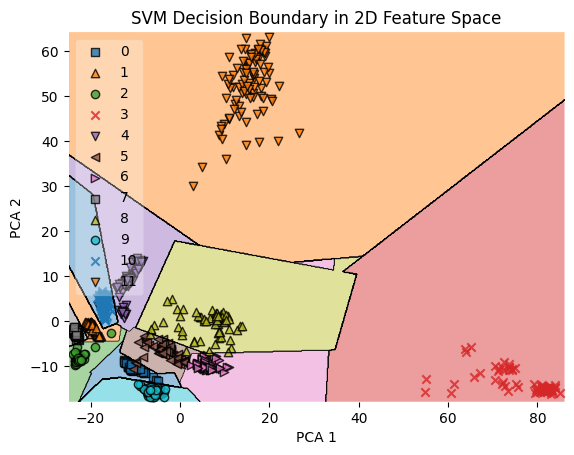

In [13]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Project features into 2D space for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train SVM on the 2D features
svm_classifier_2d = SVC(kernel='linear')
svm_classifier_2d.fit(X_train_pca, y_train)

# Plot decision regions
plot_decision_regions(X_train_pca, y_train.astype(np.integer), clf=svm_classifier_2d, legend=2)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('SVM Decision Boundary in 2D Feature Space')
plt.show()

# Predictions

In [10]:
import cv2
import face_recognition
import numpy as np
import datetime

# Load the trained model
model = load_model('model.h5')

# Reverse the map to get integer to label map
int_to_label_map = {v: k for k, v in label_to_int_map.items()}

# Initialize the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture frame")
        break

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_frame = frame[:, :, ::-1]

    # Find all the faces in the current frame of video
    face_locations = face_recognition.face_locations(rgb_frame)

    # If faces were found, we will mark the image
    for top, right, bottom, left in face_locations:
        # You can access the actual face itself like this:
        face_image = frame[top:bottom, left:right]
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        face_image = cv2.resize(face_image, (128, 128))  # Resize to the size expected by the model
        face_image = face_image / 255.0  # Normalize pixel values
        face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension
        face_image = np.expand_dims(face_image, axis=-1)  # Add channel dimension

        # Predict the label of the face
        predictions = model.predict(face_image)
        predicted_label = int_to_label_map[np.argmax(predictions)]

        # Rest of your code...

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 255, 0), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, predicted_label, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Store the key press event in a variable
    key = cv2.waitKey(1) & 0xFF

    # Break the loop on pressing 'q'
    if key == ord('q'):
        break

    # Take attendance on pressing 'a'
    if key == ord('a'):
        # Here you can add code to take attendance
        # For example, you can store the current time and the predicted label in a file
        with open('attendance.csv', 'a') as f:
            f.write(f"{predicted_label},{datetime.datetime.now()}\n")
        break

# Release handle to the webcam
cap.release()
cv2.destroyAllWindows()


NameError: name 'load_model' is not defined

In [48]:
roll_number = []
for img_name in train_contents:
    img_path = os.path.join(train_path, img_name)
    img_array = preprocess_image(img_path)
    # Extracting labels from file names
    roll_number.append(img_name.split('.')[1])

print(roll_number)

['6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [49]:
roll_number = np.array(roll_number)
print(roll_number)

['6' '6' '6' ... '18' '18' '18']


In [65]:
unique_roll_number = np.unique(roll_number)
label_to_int_roll = {name: roll for name, roll in zip(labels, roll_number)}
print(unique_roll_number)
print(label_to_int_roll)

['0' '1' '11' '12' '16' '18' '2' '20' '6' '7' '96']
{'Abir': '6', 'Fahim': '0', 'Gaurav': '96', 'Hemel': '7', 'Nipa': '20', 'Rupak': '2', 'Sabiqul': '1', 'Shepon': '11', 'Tama': '16', 'Tamim': '12', 'Tarup': '18'}


In [66]:
rolls = label_to_int_roll
print(rolls)

{'Abir': '6', 'Fahim': '0', 'Gaurav': '96', 'Hemel': '7', 'Nipa': '20', 'Rupak': '2', 'Sabiqul': '1', 'Shepon': '11', 'Tama': '16', 'Tamim': '12', 'Tarup': '18'}


In [71]:
# Create a dictionary that maps each student name to its corresponding roll number
name_to_roll_number_map = {v: k for k, v in label_to_int_roll.items()}
# interchange key and value
name_to_roll_number_map = {v: k for k, v in name_to_roll_number_map.items()}
print(name_to_roll_number_map)

{'Abir': '6', 'Fahim': '0', 'Gaurav': '96', 'Hemel': '7', 'Nipa': '20', 'Rupak': '2', 'Sabiqul': '1', 'Shepon': '11', 'Tama': '16', 'Tamim': '12', 'Tarup': '18'}


In [69]:
from tensorflow.keras.models import Model, load_model
import face_recognition
# Load the trained model
model = load_model('model.h5')

rgb_frame = frame[:, :, ::-1]
# Find all the faces in the current frame of video
face_locations = face_recognition.face_locations(rgb_frame)

# If faces were found, we will mark the image
for top, right, bottom, left in face_locations:
        # You can access the actual face itself like this:
        face_image = frame[top:bottom, left:right]
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        face_image = cv2.resize(face_image, (128, 128))  # Resize to the size expected by the model
        face_image = face_image / 255.0  # Normalize pixel values
        face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension
        face_image = np.expand_dims(face_image, axis=-1)  # Add channel dimension

# Predict the label of the face
predictions = model.predict(face_image)
predicted_class = np.argmax(predictions)
max_prediction_prob = np.max(predictions)


# Assuming `predicted_label` is the predicted student's name
predicted_roll_number = name_to_roll_number_map
print(predicted_roll_number)

E:\Python3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'6': 'Abir', '0': 'Fahim', '96': 'Gaurav', '7': 'Hemel', '20': 'Nipa', '2': 'Rupak', '1': 'Sabiqul', '11': 'Shepon', '16': 'Tama', '12': 'Tamim', '18': 'Tarup'}
